# Chess Game Dataset Preprocessing
This notebook demonstrates data preprocessing techniques applied to a chess game dataset.  
The key steps include:
- Outlier detection and removal using Linear Quadratic Regulator (LQR)
- Normalization using log transformations and IQR-based techniques
- Encoding categorical features
- Feature engineering, such as time control conversion and rating tier assignment
- Data visualization and handling missing values

## Step 1: Load Dataset and Overview
We begin by loading the dataset and reviewing its structure.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
import joblib

# Load dataset
data_df = pd.read_csv('games.csv')
print("Dataset shape:", data_df.shape)
data_df.info()

Dataset shape: (20058, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memor

In [147]:
# Rename columns for easier reference
data_df.columns = [
    'Game_ID', 'Rated_(T/F)', 'Start_Time', 'End_Time', 
    'Number_of_Turns', 'Game_Status', 'Winner', 'Time_Increment',
    'White_ID', 'White_Rating', 'Black_ID',
    'Black_Rating', 'Moves',
    'Opening_Eco', 'Opening_Name', 'Opening_Ply'
]

In [148]:
# Convert timestamps to datetime, handle errors, and fill missing values
data_df['Start_Time'] = pd.to_datetime(data_df['Start_Time'], unit='ms', errors='coerce').fillna(pd.Timestamp('1970-01-01'))
data_df['End_Time'] = pd.to_datetime(data_df['End_Time'], unit='ms', errors='coerce').fillna(pd.Timestamp('1970-01-01'))

# Calculate 'Game_Duration' in minutes and handle cases with zero duration
data_df['Game_Duration'] = (data_df['End_Time'] - data_df['Start_Time']).dt.total_seconds()
data_df.loc[data_df['Start_Time'] == data_df['End_Time'], 'Game_Duration'] = 1

# Remove rows with Game_Duration == 1
data_df = data_df[data_df['Game_Duration'] > 1]

# Remove rows where Game_Duration is divisible by 10
data_df = data_df[data_df['Game_Duration'] % 10 != 0]

## Step 2: Outlier Detection and Removal
We use Linear Quadratic Regulator (LQR) to identify and remove outliers.

In [149]:
# Define LQR for outlier detection
def detect_outliers_lqr(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Remove outliers
numeric_columns = data_df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    outliers = detect_outliers_lqr(data_df, col)
    data_df = data_df.drop(outliers.index)

print("Dataset shape after outlier removal:", data_df.shape)

Dataset shape after outlier removal: (9264, 17)


## Step 3: Visualization of Important Features
We analyze the distribution of features like `Number_of_Turns`.

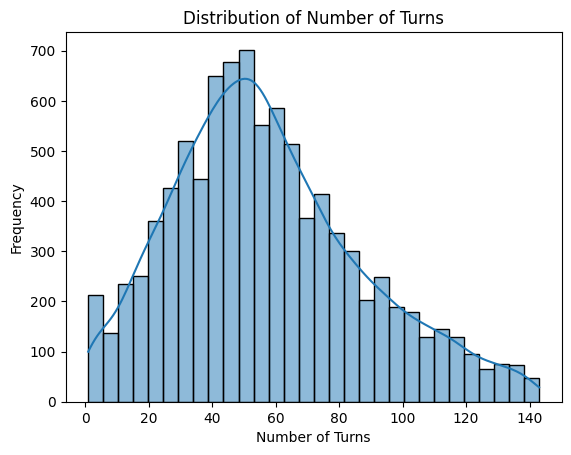

Skewness: 0.5332587911592576
Kurtosis: -0.11026781835961819


In [150]:
sns.histplot(data_df['Number_of_Turns'], bins=30, kde=True, edgecolor='black')
plt.title('Distribution of Number of Turns')
plt.xlabel('Number of Turns')
plt.ylabel('Frequency')
plt.show()

# Check skewness and kurtosis
print("Skewness:", skew(data_df['Number_of_Turns']))
print("Kurtosis:", kurtosis(data_df['Number_of_Turns']))

## Step 4: Feature Engineering
### 4.1 Time Control Conversion
Convert time control formats (e.g., `5+0`) into total minutes.

In [151]:
def convert_time_control(tc):
    try:
        base, increment = map(int, tc.split('+'))
        return base + increment / 60
    except:
        return np.nan

data_df['Time_Increment'] = data_df['Time_Increment'].apply(convert_time_control)
data_df['Time_Increment'].fillna(data_df['Time_Increment'].median(), inplace=True)

C:\Users\Kshitish Pandit\AppData\Local\Temp\ipykernel_6304\452585482.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df['Time_Increment'].fillna(data_df['Time_Increment'].median(), inplace=True)


### 4.2 Rating Tiers
Assign players into rating tiers (e.g., Beginner, Intermediate).

In [152]:
bins = [0, 1200, 1600, 2000, float('inf')]
labels = ['Beginner', 'Intermediate', 'Advanced', 'Master']
data_df['White_Rating_Tier'] = pd.cut(data_df['White_Rating'], bins=bins, labels=labels)
data_df['Black_Rating_Tier'] = pd.cut(data_df['Black_Rating'], bins=bins, labels=labels)

## Step 5: Encoding Categorical Features
Apply label and ordinal encoding for categorical columns.

In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
nominal_columns = ['Winner','Opening_Eco', 'Opening_Name','Moves']
for col in nominal_columns:
    data_df[col] = label_encoder.fit_transform(data_df[col])
# One-Hot Encoding
onehot_encoder = OneHotEncoder(sparse=False)
moves_encoded = onehot_encoder.fit_transform(data_df[['Moves']])
moves_encoded_df = pd.DataFrame(moves_encoded, columns=onehot_encoder.get_feature_names_out(['Moves']))
data_df = data_df.join(moves_encoded_df)

# Ordinal Encoding
ordinal_encoder = OrdinalEncoder()
ordinal_columns = ['Rated_(T/F)', 'Game_Status', 'White_Rating_Tier', 'Black_Rating_Tier']
data_df[ordinal_columns] = ordinal_encoder.fit_transform(data_df[ordinal_columns])

# Save encoders
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(ordinal_encoder, 'ordinal_encoder.pkl')
joblib.dump(onehot_encoder, 'onehot_encoder.pkl')

['ordinal_encoder.pkl']

## Step 6: Save Preprocessed Data
Export the cleaned dataset and target column to CSV files.

In [154]:
data_df = data_df.drop(columns=['White_Rating', 'Black_Rating','Game_ID','White_ID','Black_ID','Start_Time','End_Time'])

# Save data
data_df.to_csv('Clean_Chess_Data.csv', index=False)